# 前期准备

导入所需库

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import os
import chinese_calendar as cc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pickle

设置中文字体

In [2]:
def get_system_font():
    if platform.system() == 'Darwin':  # macOS
        # macOS 常见中文字体路径
        font_paths = [
            '/System/Library/Fonts/PingFang.ttc',
            '/System/Library/Fonts/STHeiti Light.ttc',
            '/System/Library/Fonts/STHeiti Medium.ttc',
            '/Library/Fonts/Microsoft/SimHei.ttf'
        ]
    else:  # Linux/Windows
        font_paths = [
            '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
            '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf'
        ]
    
    # 尝试找到可用的中文字体
    for path in font_paths:
        if os.path.exists(path):
            return path
            
    # 如果找不到预定义的字体，使用系统默认中文字体
    chinese_fonts = [f for f in fm.findSystemFonts() if 'noto' in f.lower() or 'ping' in f.lower() or 'heiti' in f.lower()]
    return chinese_fonts[0] if chinese_fonts else None

# 设置中文字体
try:
    font_path = get_system_font()
    if font_path:
        plt.rcParams['font.family'] = ['sans-serif']
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
    else:
        # 使用内置的中文字体
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
except Exception as e:
    print(f"设置中文字体时出错: {str(e)}")
    # 使用备选方案
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

print(font_prop)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/System/Library/Fonts/STHeiti Light.ttc:size=10.0


# 数据预处理

读取并合并市场披露数据（包括对齐24个点和96个点的数据）

In [3]:
data_path = "../data/"
data_path_2024 = data_path + "2024/"
data_path_2025 = data_path + "2025/"

elec_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024新能源出力数据_96点_cleaned.csv", sep="\t")

df_15_features = [elec_out_price_df_2024, non_martket_elec_gen_df_2024, ele_load_df_2024, new_energy_elec_gen_df_2024]

for i in range(len(df_15_features)):
    df = df_15_features[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').mean()
    df_15_features[i] = df

elec_price_df_2024['datetime'] = pd.to_datetime(elec_price_df_2024['datetime'])
elec_price_df_2024.set_index('datetime', inplace=True)

merged_df = pd.concat([elec_price_df_2024] + df_15_features, axis=1)
print(merged_df.loc['2024-01-02'])

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57     372.27  2100.0000   
2024-01-02 01:00:00    364.71     347.72     378.77     274.10  2100.0000   
2024-01-02 02:00:00    386.24     384.98     387.28     221.28  2099.9975   
2024-01-02 03:00:00    388.32     389.00     387.76     216.79  2100.0000   
2024-01-02 04:00:00    280.56     210.77     338.91     208.40  2100.0000   
2024-01-02 05:00:00    326.74     275.32     369.84       0.25  2100.0000   
2024-01-02 06:00:00    370.06     346.92     389.27       0.85  2100.0000   
2024-01-02 07:00:00    408.80     416.22     402.58      17.32  2100.0000   
2024-01-02 08:00:00    413.95     412.62     415.12     259.53  2755.5000   
2024-01-02 09:00:00    296.40     220.77     366.52     299.84  3805.5000   
2024-01-02 10:00:00    171.27     139.11     201.10     158.74  4200.0000   

预处理天气数据

In [4]:
weather_data_2024_all = pd.read_csv(data_path_2024 + '内蒙2024天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2024_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2024 = weather_data_2024_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2024['datetime'] = pd.to_datetime(weather_data_2024['datetime'], dayfirst=True)
weather_data_2024.set_index('datetime', inplace=True)
weather_data_2024_filtered = weather_data_2024[weather_data_2024['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2024 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

print(merged_weather_2024.loc['2024-01-02'][0:3])

                     t2m_1501  ws10m_1501  ssrd_1501  tp_1501  rh_1501  \
datetime                                                                 
2024-01-02 00:00:00   -9.3586      0.8648        0.0      0.0   0.7457   
2024-01-02 01:00:00  -10.2181      0.7868        0.0      0.0   0.7487   
2024-01-02 02:00:00  -10.1093      0.8430        0.0      0.0   0.7481   

                     t2m_1502  ws10m_1502  ssrd_1502  tp_1502  rh_1502  
datetime                                                                
2024-01-02 00:00:00  -12.7961      2.0977        0.0      0.0   0.7343  
2024-01-02 01:00:00  -14.1596      2.5779        0.0      0.0   0.7424  
2024-01-02 02:00:00  -14.6581      2.8571        0.0      0.0   0.7470  


合并数据+丢弃预测数据

In [5]:
merged_df_with_weather = merged_df.merge(merged_weather_2024, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷实测'] + merged_df_with_weather['东送计划实测'] - merged_df_with_weather['新能源出力实测'] - merged_df_with_weather['非市场出力计划实测']
merged_df_filtered = merged_df_with_weather.drop(columns=['日前预出清电能价格', '东送计划预测', '非市场出力计划', '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测'])

print(merged_df_filtered.loc['2024-01-02'][0:3])

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价     东送计划实测  非市场出力计划实测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57  2140.2275  6770.1775   
2024-01-02 01:00:00    364.71     347.72     378.77  2116.7025  6634.9475   
2024-01-02 02:00:00    386.24     384.98     387.28  2107.8150  6606.2650   

                        统调负荷实测     新能源出力实测     风电出力实测   光伏出力实测  t2m_1501  \
datetime                                                                   
2024-01-02 00:00:00  40525.650  14502.4325  14525.800 -23.3675   -9.3586   
2024-01-02 01:00:00  40046.850  14219.4650  14243.575 -24.1100  -10.2181   
2024-01-02 02:00:00  40029.675  13947.3600  13971.750 -24.3900  -10.1093   

                     ws10m_1501  ssrd_1501  tp_1501  rh_1501  t2m_1502  \
datetime                                                                 
2024-01-02 00:00:00      0.8648        0.0      0.0   0.7457  -12.7961   
2024-01-02 

特征相关性

In [6]:
merged_df_filtered.corr()

,全网统一出清电价,呼包东统一出清电价,呼包西统一出清电价,东送计划实测,非市场出力计划实测,统调负荷实测,新能源出力实测,风电出力实测,光伏出力实测,t2m_1501,ws10m_1501,ssrd_1501,tp_1501,rh_1501,t2m_1502,ws10m_1502,ssrd_1502,tp_1502,rh_1502,price_bidding_space
全网统一出清电价,1.000000,0.994651,0.995848,-0.278192,0.059353,0.235745,-0.664053,-0.568012,-0.295194,0.024133,-0.326692,-0.226712,-0.052249,0.062322,0.025129,-0.335770,-0.227465,-0.041945,0.030401,0.717769
呼包东统一出清电价,0.994651,1.000000,0.981162,-0.276635,0.043392,0.226383,-0.667081,-0.584935,-0.277954,0.043346,-0.328372,-0.212769,-0.049954,0.075304,0.044744,-0.332523,-0.212559,-0.039776,0.041759,0.720289
呼包西统一出清电价,0.995848,0.981162,1.000000,-0.277318,0.073007,0.242139,-0.655440,-0.547511,-0.308394,0.006499,-0.322139,-0.237682,-0.053813,0.050642,0.007183,-0.335598,-0.239284,-0.043495,0.020463,0.709139
东送计划实测,-0.278192,-0.276635,-0.277318,1.000000,0.039572,0.261283,0.496155,0.350433,0.316463,0.186764,0.234266,0.283224,-0.000106,-0.192659,0.189452,0.256420,0.287720,-0.009806,-0.216764,-0.254903
非市场出力计划实测,0.059353,0.043392,0.073007,0.039572,1.000000,0.161270,-0.074244,0.272012,-0.468060,-0.167275,-0.109703,-0.486121,-0.005490,0.109429,-0.170530,-0.036835,-0.493855,-0.007438,0.102488,0.016622
统调负荷实测,0.235745,0.226383,0.242139,0.261283,0.161270,1.000000,0.108947,0.139844,-0.012064,-0.347241,-0.095482,-0.053915,-0.126124,-0.109990,-0.334491,-0.042961,-0.051732,-0.124303,-0.119020,0.228174
新能源出力实测,-0.664053,-0.667081,-0.655440,0.496155,-0.074244,0.108947,1.000000,0.768204,0.557561,0.007418,0.530365,0.492835,-0.007194,-0.306876,0.011896,0.562645,0.503055,-0.015747,-0.314058,-0.922730
风电出力实测,-0.568012,-0.584935,-0.547511,0.350433,0.272012,0.139844,0.768204,1.000000,-0.103137,-0.193885,0.361313,-0.113572,0.039485,-0.042642,-0.195809,0.449467,-0.107924,0.036565,-0.040415,-0.736926
光伏出力实测,-0.295194,-0.277954,-0.308394,0.316463,-0.468060,-0.012064,0.557561,-0.103137,1.000000,0.262880,0.355770,0.913091,-0.062368,-0.421598,0.272336,0.291616,0.921630,-0.071873,-0.435631,-0.478067
t2m_1501,0.024133,0.043346,0.006499,0.186764,-0.167275,-0.347241,0.007418,-0.193885,0.262880,1.000000,0.173754,0.387234,0.104900,-0.154358,0.991427,0.146635,0.392254,0.107402,-0.213648,-0.059669


创建电价的滞后特征

In [7]:
# merged_df_filtered['east_price_lag_1'] = merged_df_filtered['呼包东统一出清电价'].shift(1)
# merged_df_filtered['east_price_lag_2'] = merged_df_filtered['呼包东统一出清电价'].shift(2)
# merged_df_filtered['east_price_lag_3'] = merged_df_filtered['呼包东统一出清电价'].shift(3)

# merged_df_filtered['west_price_lag_1'] = merged_df_filtered['呼包西统一出清电价'].shift(1)
# merged_df_filtered['west_price_lag_2'] = merged_df_filtered['呼包西统一出清电价'].shift(2)
# merged_df_filtered['west_price_lag_3'] = merged_df_filtered['呼包西统一出清电价'].shift(3)

# for day in range(1, 8):
#     merged_df_filtered[f'east_price_lag_day_{day}'] = merged_df_filtered['呼包东统一出清电价'].shift(24 * day)
#     merged_df_filtered[f'west_price_lag_day_{day}'] = merged_df_filtered['呼包西统一出清电价'].shift(24 * day)

merged_df_filtered = merged_df_filtered.dropna()

print(merged_df_filtered.head())

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价     东送计划实测  非市场出力计划实测  \
datetime                                                                    
2024-01-01 09:00:00    430.32     426.92     433.48  3764.4200  6984.4300   
2024-01-01 10:00:00    409.45     407.92     410.91  4175.0450  6923.6375   
2024-01-01 11:00:00    384.81     397.11     373.26  4304.6000  6655.7350   
2024-01-01 12:00:00    348.15     354.58     342.46  3263.3575  5861.5700   
2024-01-01 13:00:00      8.24       0.00      15.26  2890.0625  5942.5800   

                        统调负荷实测     新能源出力实测     风电出力实测     光伏出力实测  t2m_1501  \
datetime                                                                     
2024-01-01 09:00:00  40678.325  13500.9825  12978.950   522.0325  -12.9174   
2024-01-01 10:00:00  40749.050  14903.1650  12327.975  2575.1900   -8.6728   
2024-01-01 11:00:00  40923.300  16714.9325  11530.125  5184.8075   -9.0334   
2024-01-01 12:00:00  40969.525  18078.4975  10691.325  7387.1725   -8.

添加节假日、季节、工作日与周末、星期几特征

In [8]:
merged_df_filtered['weekday_num'] = merged_df_filtered.index.weekday
merged_df_filtered['is_workday'] = (merged_df_filtered['weekday_num'] < 5).astype(int)
merged_df_filtered['is_holiday'] = merged_df_filtered.index.to_series().apply(lambda x : 1 if cc.is_holiday(x.date()) else 0)

def get_season(month):
    if month in [3, 4, 5]:
        return 0 # Spring
    elif month in [6, 7, 8]:
        return 1 # Summer
    elif month in [9, 10, 11]:
        return 2 # Autumn
    else:
        return 3 # Winter

merged_df_filtered['season'] = merged_df_filtered.index.month.map(get_season)

print(merged_df_filtered.columns)

print(merged_df_filtered.loc['2024-10-01'][0:1])
print(merged_df_filtered.loc['2024-10-02'][0:1])
print(merged_df_filtered.loc['2024-03-01'][0:1])

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '东送计划实测', '非市场出力计划实测', '统调负荷实测',
       '新能源出力实测', '风电出力实测', '光伏出力实测', 't2m_1501', 'ws10m_1501', 'ssrd_1501',
       'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502', 'ssrd_1502', 'tp_1502',
       'rh_1502', 'price_bidding_space', 'weekday_num', 'is_workday',
       'is_holiday', 'season'],
      dtype='object')
            全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价     东送计划实测  非市场出力计划实测   统调负荷实测  \
datetime                                                                    
2024-10-01   25.8795    8.52343    41.0747  1349.4225  7649.2475  37822.3   

               新能源出力实测     风电出力实测  光伏出力实测  t2m_1501  ...  t2m_1502  \
datetime                                             ...             
2024-10-01  15360.4025  15367.975 -7.5725     4.403  ...    4.4284   

            ws10m_1502  ssrd_1502  tp_1502  rh_1502  price_bidding_space  \
datetime                                                                   
2024-10-01      3.4991        0.0      0.0   0.

检查并处理缺失数据

In [9]:
def deal_missing_data(df_data):
    complete_time_range = pd.date_range(
        start=merged_df_filtered.index.min(),
        end=merged_df_filtered.index.max(),
        freq='h'
    )
    initial_missing = complete_time_range.difference(merged_df_filtered.index)
    print(f"Initial missing timestamps: {len(initial_missing)}")
    if len(initial_missing) == 0:
        print("No need to deal missing data.")
        return df_data

    print("Dealing with missing data.")
    print("Initial missing dates:", pd.Series(initial_missing.date).value_counts())

    df_reindexed = df_data.reindex(complete_time_range)
    df_reindexed['date'] = df_reindexed.index.date
    missing_flag = df_reindexed.drop(columns='date').isna().any(axis=1)
    missing_count_per_day = missing_flag.groupby(df_reindexed['date']).sum()
    print("Missing timestamps per day:")
    print(missing_count_per_day)

    threshold = 8
    days_to_drop = missing_count_per_day[missing_count_per_day > threshold].index
    print(f"\nDays to drop: {len(days_to_drop)}")

    df_cleaned = df_reindexed[~df_reindexed['date'].isin(days_to_drop)].copy()
    df_cleaned.drop(columns='date', inplace=True)
    
    df_filled = df_cleaned.interpolate(method='time')

    expected_range = pd.date_range(
        start=df_filled.index.min(),
        end=df_filled.index.max(),
        freq='h'
    )
    missing_timestamps = expected_range.difference(df_filled.index)
    print(f"Total missing timestamps: {len(missing_timestamps)}")
    print("\nMissing timestamps by date:")
    missing_dates = pd.Series(missing_timestamps.date).value_counts().sort_index()
    print(missing_dates)
    
    return df_filled

df_cleaned = deal_missing_data(merged_df_filtered)

Initial missing timestamps: 0
No need to deal missing data.


归一化之前导出到csv保存

In [10]:
df_cleaned.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划实测': 'east_trans_load', 
    '非市场出力计划实测': 'non_market_output_load',
    '统调负荷实测': 'unified_dispatch_load',
    '新能源出力实测': 'new_energy_output_load',
    '风电出力实测': 'wind_power_output_load',
    '光伏出力实测': 'solar_power_output_load'
}, inplace=True)
print(df_cleaned.columns)
df_cleaned.to_csv("../output/df_cleaned.csv", index=True, encoding="utf-8-sig")

Index(['unified_price', 'east_price', 'west_price', 'east_trans_load',
       'non_market_output_load', 'unified_dispatch_load',
       'new_energy_output_load', 'wind_power_output_load',
       'solar_power_output_load', 't2m_1501', 'ws10m_1501', 'ssrd_1501',
       'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502', 'ssrd_1502', 'tp_1502',
       'rh_1502', 'price_bidding_space', 'weekday_num', 'is_workday',
       'is_holiday', 'season'],
      dtype='object')


归一化

In [11]:
print("Before normalized:")
print(df_cleaned.head(1))

columns_to_scale = [col for col in df_cleaned.columns if col not in ['weekday_num', 'is_workday', 'is_holiday', 'season']]
normalized_df = df_cleaned.copy()

scalers = {}

for col in columns_to_scale:
    if 'price' in col:
        scaler = RobustScaler()
    elif 'load' in col:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    normalized_df[col] = scaler.fit_transform(normalized_df[[col]])
    scalers[col] = scaler

with open('../scaler_model/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("After normalized:")
print(normalized_df.head(1))

normalized_df.to_csv("../output/normalized_df.csv", index=True, encoding="utf-8-sig")

Before normalized:
                     unified_price  east_price  west_price  east_trans_load  \
datetime                                                                      
2024-01-01 09:00:00         430.32      426.92      433.48          3764.42   

                     non_market_output_load  unified_dispatch_load  \
datetime                                                             
2024-01-01 09:00:00                 6984.43              40678.325   

                     new_energy_output_load  wind_power_output_load  \
datetime                                                              
2024-01-01 09:00:00              13500.9825                12978.95   

                     solar_power_output_load  t2m_1501  ...  t2m_1502  \
datetime                                                ...             
2024-01-01 09:00:00                 522.0325  -12.9174  ...  -16.2416   

                     ws10m_1502  ssrd_1502  tp_1502  rh_1502  \
datetime                          

# 训练模型

环境设置

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

搭建模型

In [13]:
def create_sliding_windows(data, input_length, output_length, target_indices):
    """
    构造滑动窗口数据
    :param data: numpy 数组，形状 (T, num_features)
    :param input_length: 输入序列长度（例如24个点代表1天）
    :param output_length: 输出序列长度（预测下一天的24个点）
    :param target_indices: 目标特征在数据中的索引列表
    :return: X, Y，分别为输入和目标序列
    """
    # 参数验证
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype=np.float32)
    
    if len(data.shape) != 2:
        raise ValueError(f"数据维度必须为2，当前维度为 {len(data.shape)}")
        
    total_length, num_features = data.shape
    min_length = input_length + output_length
    print(f'total_length: {total_length}, num_features: {num_features}, min_length: {min_length}')
    
    if total_length < min_length:
        raise ValueError(f"数据长度({total_length})小于所需最小长度({min_length})")
        
    if max(target_indices) >= num_features:
        raise ValueError(f"目标特征索引超出范围: {target_indices}, 特征数量: {num_features}")

    try:
        # 预分配内存
        samples_count = total_length - input_length - output_length + 1
        X = np.zeros((samples_count, input_length, num_features), dtype=np.float32)
        Y = np.zeros((samples_count, output_length, len(target_indices)), dtype=np.float32)
        
        # 构建滑动窗口
        for i in range(samples_count):
            X[i] = data[i:i + input_length]
            Y[i] = data[i + input_length:i + input_length + output_length][:, target_indices]
            
        return X, Y
        
    except Exception as e:
        print(f"创建滑动窗口时发生错误: {str(e)}")
        raise

# 检查输入数据
if not isinstance(normalized_df, (np.ndarray, pd.DataFrame)):
    raise TypeError("normalized_df 必须是 numpy 数组或 pandas DataFrame")

# 数据预处理
data_array = normalized_df.astype(np.float32)
target_columns = ['east_price', 'west_price']

# 获取目标特征的索引
features = normalized_df.columns.tolist()
target_indices = [features.index(col) for col in target_columns]

# 参数设置
input_length = 48    # 输入序列长度：2天数据
output_length = 24   # 输出序列长度：预测下一天

# 构造滑动窗口数据
X, Y = create_sliding_windows(data_array, input_length, output_length, target_indices)
print(f"\n数据集信息:")
print(f"样本总数: {X.shape[0]}")
print(f"输入形状: {X.shape[1:]} (时间步, 特征数)")
print(f"输出形状: {Y.shape[1:]} (预测步数, 目标特征数)")

# 构造 PyTorch Dataset 和 DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        """
        :param X: numpy 数组，形状 (num_samples, input_length, num_features)
        :param Y: numpy 数组，形状 (num_samples, output_length, num_target_features)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 划分训练集和验证集
split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_val, Y_val = X[split_idx:], Y[split_idx:]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 构建 DLinear 模型
class DLinear(nn.Module):
    def __init__(self, input_length, output_length, num_features, target_feature_num, target_indices):
        """
        :param input_length: 输入序列的时间步数
        :param output_length: 输出序列的时间步数
        :param num_features: 输入特征数量
        :param target_feature_num: 目标特征数量（目前是2个区域的电价）
        :param target_indices: 目标特征在所有特征中的索引列表
        """
        super(DLinear, self).__init__()
        # 为每个输入特征创建一个独立的线性层
        self.linear_layers = nn.ModuleList([
            nn.Linear(input_length, output_length) for _ in range(num_features)
        ])
        self.num_features = num_features
        self.target_feature_num = target_feature_num
        self.target_indices = target_indices
        
    def forward(self, x):
        """
        :param x: 输入张量，形状 (batch_size, input_length, num_features)
        :return: 预测结果，形状 (batch_size, output_length, target_feature_num)
        """
        out_list = []
        # 对每个特征独立进行预测
        for i, layer in enumerate(self.linear_layers):
            # 取出第 i 个特征，形状：(batch_size, input_length)
            xi = x[:, :, i]
            # 线性预测得到：(batch_size, output_length)
            yi = layer(xi)
            out_list.append(yi.unsqueeze(-1))  # 变为 (batch_size, output_length, 1)
        # 拼接所有特征的预测结果，形状：(batch_size, output_length, num_features)
        out = torch.cat(out_list, dim=-1)
        prediction = out[:, :, self.target_indices]
        return prediction

# 模型参数
num_features = len(features)           # 输入所有特征的数量
target_feature_num = len(target_columns) # 预测目标的数量（2个区域）

model = DLinear(input_length=input_length, 
                output_length=output_length, 
                num_features=num_features, 
                target_feature_num=target_feature_num,
                target_indices=target_indices)

print("\nDLinear 模型结构：")
print(model)

total_length: 8776, num_features: 24, min_length: 72

数据集信息:
样本总数: 8705
输入形状: (48, 24) (时间步, 特征数)
输出形状: (24, 2) (预测步数, 目标特征数)

DLinear 模型结构：
DLinear(
  (linear_layers): ModuleList(
    (0-23): 24 x Linear(in_features=48, out_features=24, bias=True)
  )
)


训练模型

Epoch 1/50 - Train Loss: 1.641948 - Val Loss: 0.859226
Epoch 2/50 - Train Loss: 1.205986 - Val Loss: 0.781036
Epoch 3/50 - Train Loss: 1.134164 - Val Loss: 0.768247
Epoch 4/50 - Train Loss: 1.106833 - Val Loss: 0.756997
Epoch 5/50 - Train Loss: 1.092027 - Val Loss: 0.748319
Epoch 6/50 - Train Loss: 1.081917 - Val Loss: 0.749280
Epoch 7/50 - Train Loss: 1.076392 - Val Loss: 0.751112
Epoch 8/50 - Train Loss: 1.070957 - Val Loss: 0.739587
Epoch 9/50 - Train Loss: 1.067060 - Val Loss: 0.739155
Epoch 10/50 - Train Loss: 1.064256 - Val Loss: 0.741091
Epoch 11/50 - Train Loss: 1.060411 - Val Loss: 0.742981
Epoch 12/50 - Train Loss: 1.059578 - Val Loss: 0.733810
Epoch 13/50 - Train Loss: 1.057271 - Val Loss: 0.732862
Epoch 14/50 - Train Loss: 1.056881 - Val Loss: 0.726919
Epoch 15/50 - Train Loss: 1.051980 - Val Loss: 0.727014
Epoch 16/50 - Train Loss: 1.051377 - Val Loss: 0.728000
Epoch 17/50 - Train Loss: 1.050519 - Val Loss: 0.727430
Epoch 18/50 - Train Loss: 1.048850 - Val Loss: 0.726514
E

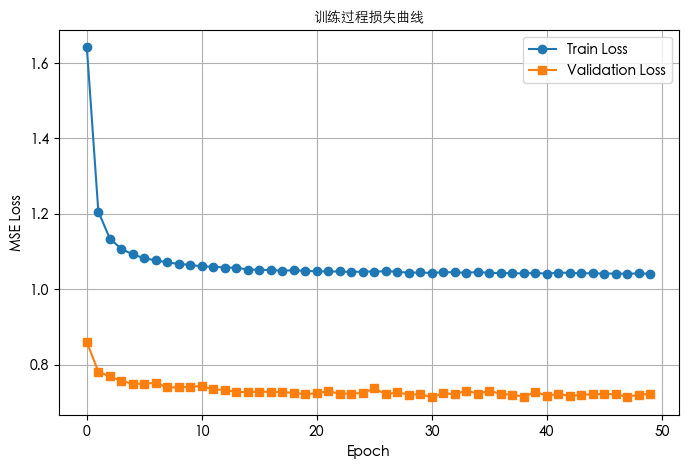

In [14]:
model.to(device)

# 定义损失函数（均方误差）和优化器（Adam）
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50  # 根据实际情况调整

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        optimizer.zero_grad()
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        # 反向传播与优化
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            epoch_val_loss += loss.item() * batch_X.size(0)
    epoch_val_loss /= len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f} - Val Loss: {epoch_val_loss:.6f}")

# 可视化训练过程
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('训练过程损失曲线', fontproperties=font_prop)
plt.legend()
plt.grid(True)
plt.show()

# 预测新数据

读取2025年新数据

In [15]:
elec_price_df_2025 = pd.read_csv(data_path_2025 + "202501电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2025 = pd.read_csv(data_path_2025 + "202501东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2025 = pd.read_csv(data_path_2025 + "202501负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501新能源处理_96点_cleaned.csv", sep="\t")

df_15_2025 = [elec_out_price_df_2025, non_martket_elec_gen_df_2025, ele_load_df_2025, new_energy_elec_gen_df_2025]

for i in range(len(df_15_2025)):
    df = df_15_2025[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').sum()
    df_15_2025[i] = df

elec_price_df_2025['datetime'] = pd.to_datetime(elec_price_df_2025['datetime'])
elec_price_df_2025.set_index('datetime', inplace=True)

merged_df_2025 = pd.concat([elec_price_df_2025] + df_15_2025, axis=1)

数据预处理

In [16]:
# 天气
weather_data_2025_all = pd.read_csv(data_path_2025 + '内蒙2025天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2025_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2025 = weather_data_2025_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2025['datetime'] = pd.to_datetime(weather_data_2025['datetime'], dayfirst=True)
weather_data_2025.set_index('datetime', inplace=True)
weather_data_2025_filtered = weather_data_2025[weather_data_2025['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2025 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

# 合并数据+丢弃预测数据
merged_df_with_weather = merged_df_2025.merge(merged_weather_2025, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷实测'] + merged_df_with_weather['东送计划实测'] - merged_df_with_weather['新能源出力实测'] - merged_df_with_weather['非市场出力计划实测']
merged_df_filtered_2025 = merged_df_with_weather.drop(columns=['日前预出清电能价格', '东送计划预测', '非市场出力计划', '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测'])

# # 滞后特征
# merged_df_filtered_2025['east_price_lag_1'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(1)
# merged_df_filtered_2025['east_price_lag_2'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(2)
# merged_df_filtered_2025['east_price_lag_3'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(3)

# merged_df_filtered_2025['west_price_lag_1'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(1)
# merged_df_filtered_2025['west_price_lag_2'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(2)
# merged_df_filtered_2025['west_price_lag_3'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(3)

# for day in range(1, 8):
#     merged_df_filtered_2025[f'east_price_lag_day_{day}'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(24 * day)
#     merged_df_filtered_2025[f'west_price_lag_day_{day}'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(24 * day)

merged_df_filtered_2025 = merged_df_filtered_2025.dropna()

# 添加节假日、季节、工作日与周末、星期几特征
merged_df_filtered_2025['weekday_num'] = merged_df_filtered_2025.index.weekday
merged_df_filtered_2025['is_workday'] = (merged_df_filtered_2025['weekday_num'] < 5).astype(int)
merged_df_filtered_2025['is_holiday'] = merged_df_filtered_2025.index.to_series().apply(lambda x : 1 if cc.is_holiday(x.date()) else 0)

merged_df_filtered_2025['season'] = merged_df_filtered_2025.index.month.map(get_season)

print(merged_df_filtered_2025.columns)

# 检查并处理缺失数据
df_cleaned_2025 = deal_missing_data(merged_df_filtered_2025)

# 重命名列名
df_cleaned_2025.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划实测': 'east_trans_load', 
    '非市场出力计划实测': 'non_market_output_load',
    '统调负荷实测': 'unified_dispatch_load',
    '新能源出力实测': 'new_energy_output_load',
    '风电出力实测': 'wind_power_output_load',
    '光伏出力实测': 'solar_power_output_load'
}, inplace=True)

# 使用已有的标准化器进行数据标准化
normalized_data_2025 = df_cleaned_2025.copy()
for col in columns_to_scale:
    scaler = scalers[col]
    normalized_data_2025[col] = scaler.transform(df_cleaned_2025[[col]])

# 使用已有的 create_sliding_windows 函数创建测试数据
X_test, Y_test = create_sliding_windows(normalized_data_2025, input_length, output_length, target_indices)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '东送计划实测', '非市场出力计划实测', '统调负荷实测',
       '新能源出力实测', '风电出力实测', '光伏出力实测', 't2m_1501', 'ws10m_1501', 'ssrd_1501',
       'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502', 'ssrd_1502', 'tp_1502',
       'rh_1502', 'price_bidding_space', 'weekday_num', 'is_workday',
       'is_holiday', 'season'],
      dtype='object')
Initial missing timestamps: 0
No need to deal missing data.
total_length: 744, num_features: 24, min_length: 72


预测

In [17]:
model.eval()  # set model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_pred = model(X_test_tensor)  # predictions in normalized scale
    Y_pred = Y_pred.numpy()  # convert predictions to numpy array for post-processing

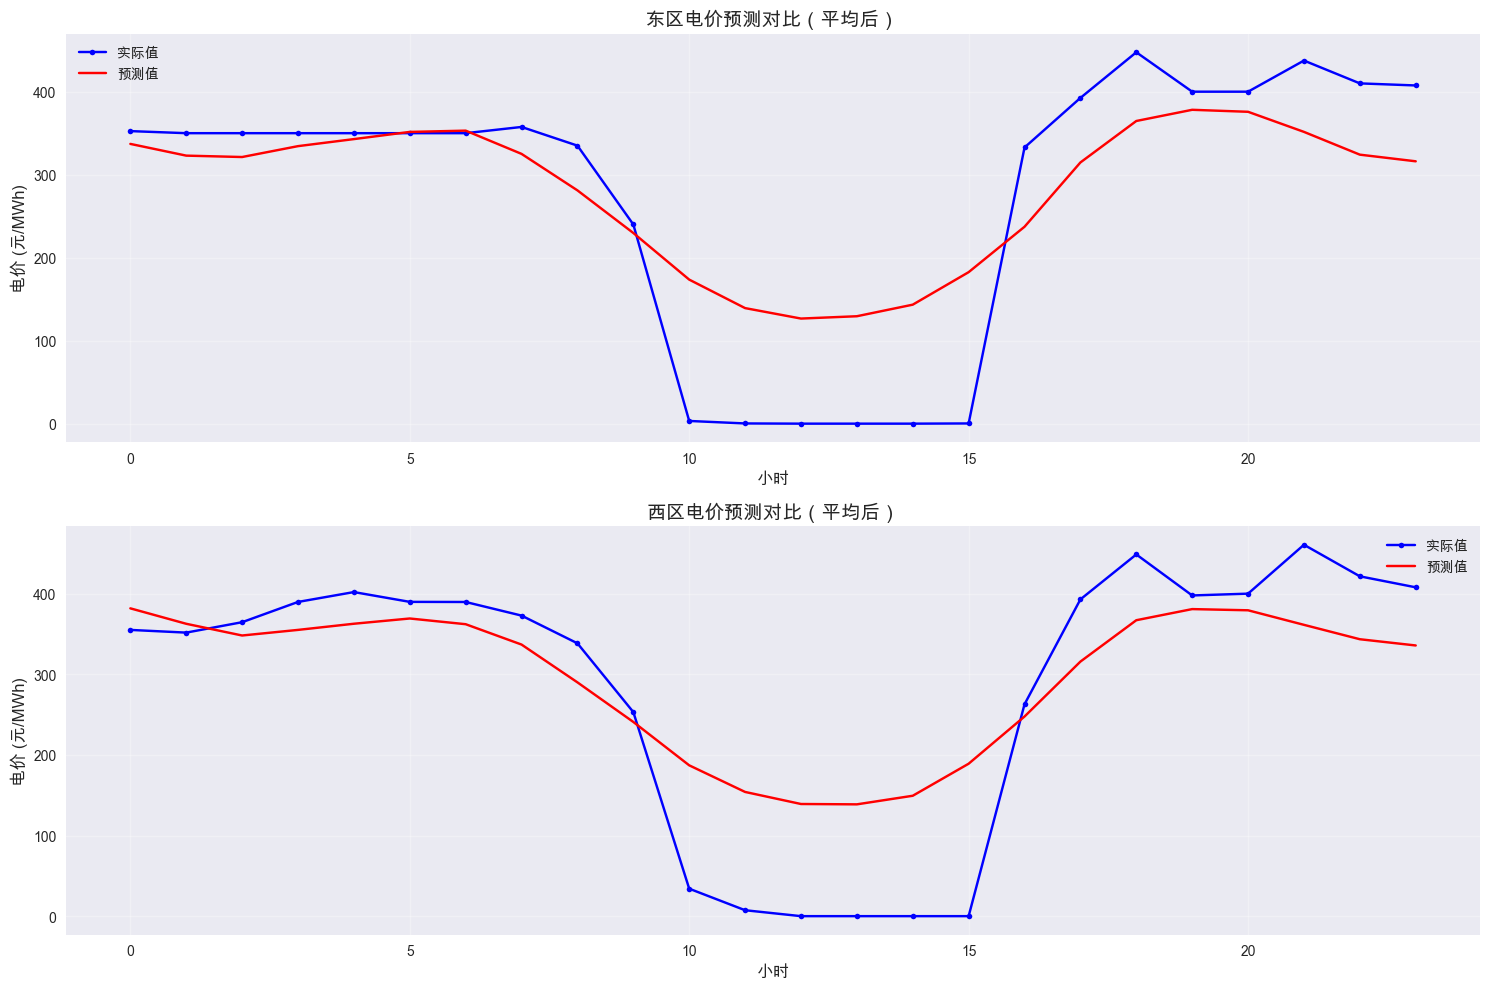


评估指标 (原始单位：元/MWh):
东区 - MSE: 74173.52, MAE: 185.07
西区 - MSE: 68821.67, MAE: 180.39

相对误差:
东区 - MAPE: 118887087.36%
西区 - MAPE: 10144681.62%


In [53]:
def process_overlapping_predictions(Y_pred, Y_test, output_length, scalers, target_columns):
    """处理滑动窗口的重叠预测值，并进行反标准化
    
    Args:
        Y_pred: 模型预测值，形状(samples, output_length, n_features)
        Y_test: 实际值，形状(samples, output_length, n_features)
        output_length: 预测序列长度（通常是24）
        scalers: 标准化器字典
        target_columns: 目标特征列名列表 ['east_price', 'west_price']
    """
    n_samples = Y_pred.shape[0]
    n_features = Y_pred.shape[2]
    
    # 创建累加器和计数器
    predictions_sum = np.zeros((n_samples + output_length - 1, n_features))
    predictions_count = np.zeros((n_samples + output_length - 1, n_features))
    true_values = np.zeros((n_samples + output_length - 1, n_features))
    
    # 累加每个滑动窗口的预测值
    for i in range(n_samples):
        for j in range(output_length):
            predictions_sum[i + j] += Y_pred[i, j]
            predictions_count[i + j] += 1
            true_values[i + j] = Y_test[i, j]
    
    # 计算平均值
    averaged_predictions = predictions_sum / predictions_count
    
    # 反标准化
    averaged_predictions_orig = np.zeros_like(averaged_predictions)
    true_values_orig = np.zeros_like(true_values)
    
    for i, col in enumerate(target_columns):
        scaler = scalers[col]
        averaged_predictions_orig[:, i] = scaler.inverse_transform(
            averaged_predictions[:, i].reshape(-1, 1)).ravel()
        true_values_orig[:, i] = scaler.inverse_transform(
            true_values[:, i].reshape(-1, 1)).ravel()
    
    return averaged_predictions_orig, true_values_orig

# 处理重叠预测并反标准化
averaged_predictions_orig, true_values_orig = process_overlapping_predictions(
    Y_pred=Y_pred, 
    Y_test=Y_test, 
    output_length=output_length,
    scalers=scalers,
    target_columns=['east_price', 'west_price']
)

# 绘制平均后的预测结果
def plot_averaged_predictions(true_values, averaged_predictions, start_idx=0, window_size=24):
    """绘制平均后的预测结果
    
    Args:
        true_values: 反标准化后的真实值
        averaged_predictions: 反标准化后的预测值
        start_idx: 起始索引
        window_size: 显示窗口大小（默认48小时）
    """
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(15, 10))
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    
    time_steps = np.arange(window_size)
    
    # 东区电价对比图
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 0], 
             label='实际值', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 0], 
             label='预测值', marker='x', markersize=4, color='red')
    plt.title(f'东区电价预测对比（平均后）', fontsize=14)
    plt.xlabel('小时', fontsize=12)
    plt.ylabel('电价 (元/MWh)', fontsize=12)  # 添加单位
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 西区电价对比图
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 1], 
             label='实际值', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 1], 
             label='预测值', marker='x', markersize=4, color='red')
    plt.title(f'西区电价预测对比（平均后）', fontsize=14)
    plt.xlabel('小时', fontsize=12)
    plt.ylabel('电价 (元/MWh)', fontsize=12)  # 添加单位
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制平均后的预测结果
plot_averaged_predictions(true_values_orig, averaged_predictions_orig, start_idx=24*27)

# 计算平均后的评估指标
mse_avg = np.mean((true_values_orig - averaged_predictions_orig) ** 2, axis=0)
mae_avg = np.mean(np.abs(true_values_orig - averaged_predictions_orig), axis=0)
print(f"\n评估指标 (原始单位：元/MWh):")
print(f"东区 - MSE: {mse_avg[0]:.2f}, MAE: {mae_avg[0]:.2f}")
print(f"西区 - MSE: {mse_avg[1]:.2f}, MAE: {mae_avg[1]:.2f}")

# 计算相对误差
mape_avg = np.mean(np.abs((true_values_orig - averaged_predictions_orig) / true_values_orig), axis=0) * 100
print(f"\n相对误差:")
print(f"东区 - MAPE: {mape_avg[0]:.2f}%")
print(f"西区 - MAPE: {mape_avg[1]:.2f}%")

反标准化

In [20]:
Y_test_orig = np.zeros_like(Y_test)
Y_pred_orig = np.zeros_like(Y_pred)

for i, col_idx in enumerate(target_indices):
    scaler = scalers[target_columns[i]]
    Y_test_orig[:, :, i] = scaler.inverse_transform(Y_test[:, :, i])
    Y_pred_orig[:, :, i] = scaler.inverse_transform(Y_pred[:, :, i])

绘制结果

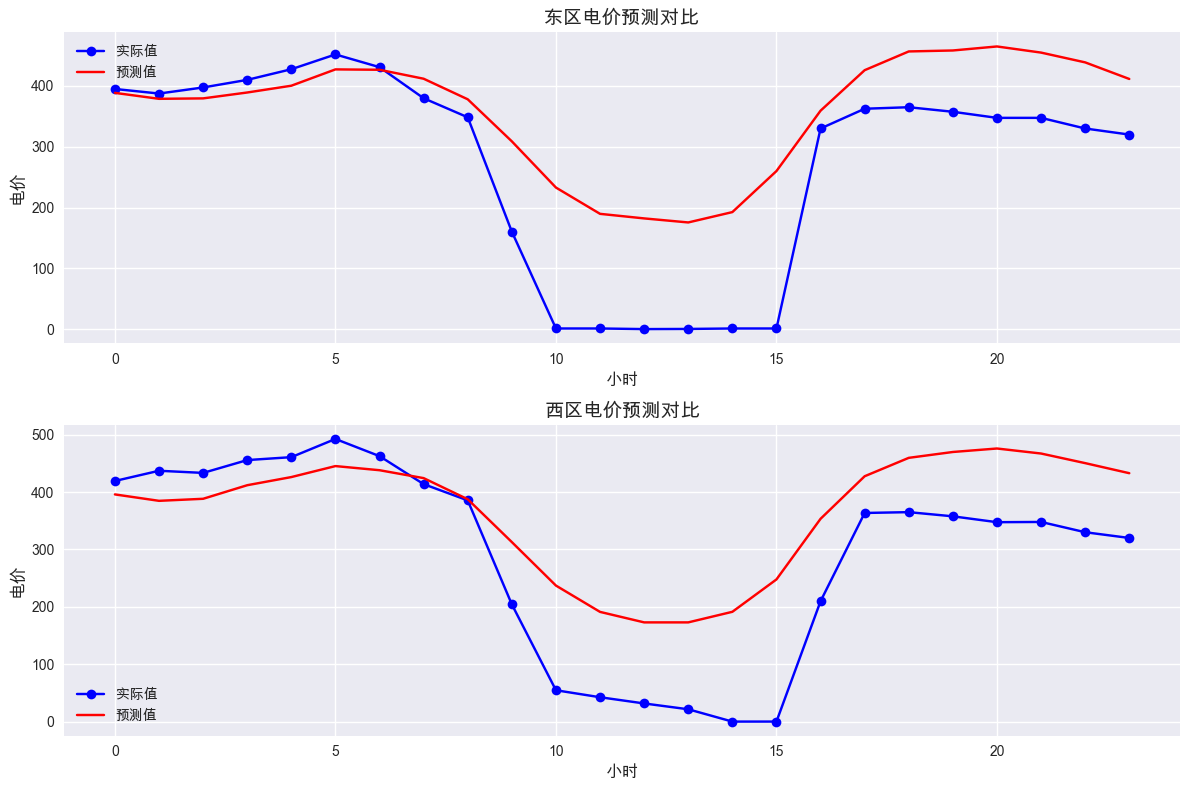


评估指标:
MSE: 85245.4297
MAE: 198.5882


In [21]:
# 定义绘图函数
def plot_predictions(Y_test, Y_pred, sample_idx=0):
    """绘制预测结果与实际值的对比图"""
    plt.style.use('seaborn-v0_8')
    output_length = Y_test.shape[1]
    time_steps = np.arange(output_length)

    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS 系统
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(12, 8))
    
    # 东区电价对比图
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, Y_test[sample_idx, :, 0], label='实际值', marker='o', color='blue')
    plt.plot(time_steps, Y_pred[sample_idx, :, 0], label='预测值', marker='x', color='red')
    plt.title(f'东区电价预测对比', fontsize=14)
    plt.xlabel('小时', fontsize=12)
    plt.ylabel('电价', fontsize=12)
    plt.legend()
    plt.grid(True)

    # 西区电价对比图
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, Y_test[sample_idx, :, 1], label='实际值', marker='o', color='blue')
    plt.plot(time_steps, Y_pred[sample_idx, :, 1], label='预测值', marker='x', color='red')
    plt.title(f'西区电价预测对比', fontsize=14)
    plt.xlabel('小时', fontsize=12)
    plt.ylabel('电价', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 绘制预测结果
plot_predictions(Y_test_orig, Y_pred_orig, 672)

# 计算评估指标
mse = np.mean((Y_test_orig - Y_pred_orig) ** 2)
mae = np.mean(np.abs(Y_test_orig - Y_pred_orig))
print(f"\n评估指标:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")